# 可以开始训练了
- by 刘道会
- 2020-08 于重庆大学

基本流程如下：
- 导入数据集
- 导入网络模型
- 定义主函数
 - 定义训练参数
 - 定义优化器
 - 定义主循环

## 0.正式开始前还是简单先测试一下

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from train.cornell_pro import Cornell
from train.ggcnn import GGCNN

In [2]:
#准备数据集
cornell_data = Cornell('cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 32)

#从数据集中读取一个样本
for x,y in dataset:
    xc = x
    yc = y
    break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [3]:
#实例化一个网络
net = GGCNN(4)

#定义一个优化器
optimizer = optim.Adam(net.parameters())

#将输入传递到网络并计算输出
pos,cos,sin,width = net.forward(xc)

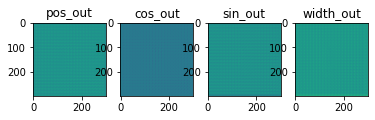

In [4]:
plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[0][0].data.numpy())
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[0][0].data.numpy())
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[0][0].data.numpy())
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[0][0].data.numpy())
plt.show()

In [5]:
#计算损失
losses = net.compute_loss(xc,yc)
loss = losses['loss']

print(loss)

tensor(0.9605, grad_fn=<AddBackward0>)


In [6]:
#反向传播优化
optimizer.zero_grad()
loss.backward()

optimizer.step()

In [7]:
losses = net.compute_loss(xc,yc)
loss = losses['loss']

print(loss)

tensor(0.9280, grad_fn=<AddBackward0>)


可以看到经过一次优化之后，loss减小了，不过一次说明不了什么，下面就在这一个样本上优化一百次，看看loss如果变得很小的话，就说明目前的工作没有跑偏，可以继续

In [8]:
'''
device = torch.device("cuda:0")

net = net.to(device)

x = xc.to(device)
y = [yy.to(device) for yy in yc]

'''
#这些是指定GPU为训练设备的代码，但不知道为什么在jupyter notebook里面会报错，但是在spyder里面是没有问题的，训练速度那叫一个快，
#因为jupyter这边主要是为了调试，也不会真的训练，所以暂时就这样吧，不管了，用cpu就用cpu吧,不过gpu的速度比cpu快了感觉不下30倍，
#因为jupyter这开始训练之后，我spyder那边调了挺久，后面又迭代了1000次，结果回过头来jupyter这还是没迭代完100次

'\ndevice = torch.device("cuda:0")\n\nnet = net.to(device)\n\nx = xc.to(device)\ny = [yy.to(device) for yy in yc]\n\n'

In [9]:
for i in range(10):
    losses = net.compute_loss(xc,yc)
    loss = losses['loss']
    print(i)
    print(loss)
    
    #反向传播优化
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

0
tensor(0.9280, grad_fn=<AddBackward0>)
1
tensor(0.8959, grad_fn=<AddBackward0>)
2
tensor(0.8614, grad_fn=<AddBackward0>)
3
tensor(0.8243, grad_fn=<AddBackward0>)
4
tensor(0.7822, grad_fn=<AddBackward0>)
5
tensor(0.7301, grad_fn=<AddBackward0>)
6
tensor(0.6647, grad_fn=<AddBackward0>)
7
tensor(0.5809, grad_fn=<AddBackward0>)
8
tensor(0.4821, grad_fn=<AddBackward0>)
9
tensor(0.3759, grad_fn=<AddBackward0>)


可以看到loss一直在降低，说明训练有效，再可视化看一下它训练完后的预测结果，所以ojbk，开整

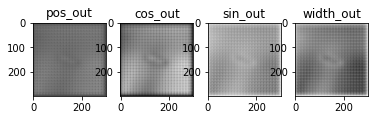

In [10]:
pos,cos,sin,width = net.forward(xc)

num = 20

plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[num][0].data.numpy(),cmap=plt.cm.gray)
plt.show()

可以看到，是比较符合预期的，所以，前面的工作已经做完了，后面可以集成了。

后面在这一个batch上迭代训练了很多次，并将过程可视化了出来，详见程序train_main1.py

## 1.导入数据集并进行必要的参数设置

In [11]:
cornell_data = Cornell('cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 32,shuffle = True)

batch_size = 32
batches_per_epoch = 1000
epochs = 30
lr = 0.001


## 2.导入网络模型并进行必要的参数设置

In [12]:
#实例化一个网络
net = GGCNN(4)

## 3.定义各个子函数

### 3.1定义训练函数

In [13]:
def train(epoch,net,device,train_data,optimizer,batches_per_epoch):
    """
    :功能: 执行一个训练epoch
    :参数: epoch             : 当前所在的epoch数
    :参数: net               : 要使用的网络模型
    :参数: device            : 训练使用的设备
    :参数: train_data        : 训练所用数据集
    :参数: optimizer         : 优化器
    :参数: batches_per_epoch : 每个epoch训练中所用的数据批数

    :返回: 本epoch的平均损失
    """
    #结果字典，最后返回用
    results = {
        'loss': 0,
        'losses': {
        }
    }
    
    #训练模式，所有的层和参数都会考虑进来，eval模式下比如dropout这种层会不使能
    net.train()
    
    batch_idx = 0
    
    #开始样本训练迭代
    while batch_idx < batches_per_epoch:
        for x, y in train_data:
            batch_idx += 1
            if batch_idx >= batches_per_epoch:
                break
            
            #将数据传到GPU，目前jupyter下无法使用
            # xc = x.to(device)
            # yc = [yy.to(device) for yy in y]
            
            lossdict = net.compute_loss(x,y)
            
            #获取当前损失
            loss = lossdict['loss']
            
            #打印一下训练过程
            if batch_idx % 2 == 0:
                print('Epoch: {}, Batch: {}, Loss: {:0.4f}'.format(epoch, batch_idx, loss.item()))
            
            #记录总共的损失
            results['loss'] += loss.item()
            #单独记录各项损失，pos,cos,sin,width
            for ln, l in lossdict['losses'].items():
                if ln not in results['losses']:
                    results['losses'][ln] = 0
                results['losses'][ln] += l.item()
            
            #反向传播优化模型
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #计算总共的平均损失
        results['loss'] /= batch_idx
        
        #计算各项的平均损失
        for l in results['losses']:
            results['losses'][l] /= batch_idx
        return results

In [14]:
def run():
    #获取设备
    device = torch.device("cuda:0")
    #net = net.to(device)
    
    #设置优化器
    optimizer = optim.Adam(net.parameters())
    
    #开始主循环
    for epoch in range(epochs):
        train_results = train(epoch, net, device, dataset, optimizer, batches_per_epoch)

In [15]:
run()

260
141
512
75
10
861
354
626
428
76
685
148
484
797
116
665
299
660
77
759
176
589
879
26
328
572
43
625
135
319
268
343
216
399
817
385
262
218
298
165
576
46
283
241
277
72
830
597
442
527
339
459
327
605
557
74
430
221
95
599
220
257
694
206
Epoch: 0, Batch: 2, Loss: 0.9946
617
525
474
312
338
427
323
600
441
804
767
530
58
44
280
738
570
230
169
741
846
137
773
571
436
657
317
526
775
30
329
737
173
362
516
700
48
253
278
282
517
507
798
219
787
872
208
702
654
345
90
670
679
232
227
778
78
651
175
378
355
451
270
680
Epoch: 0, Batch: 4, Loss: 0.9410
373
196
384
184
678
772
396
392
65
458
843
604
332
4
214
111
615
789
839
322
553
575
769
482
682
749
628
807
98
346
275
862
195
518
182
177
760
231
51
6
848
147
689
414
790
114
470
127
758
365
548
315
635
561
381
413
508
585
60
688
439
771
154
648
Epoch: 0, Batch: 6, Loss: 0.8491
86
102
821
160
835
240
762
502
170
868
276
417
731
498
673
781
726
120
70
406
457
598
25
39
358
592
0
418
709
200
204
669
3
828
279
361
656
314
349
739
383
5

KeyboardInterrupt: 

这边训练的时候，一开始没问题，后面报了这个错误，说是维度不匹配，有的图是[4,299,300]，这就说明是裁剪那块出了问题，上网查了一下也没什么结果，不过好在这是复现，ggcnn那边没报错，就说明它肯定是解决了这个问题的，cornell_data里面的get_depth和git_rgb有个resize函数，估计是解决这个问题的，我拿来试试

果然解决了，不过又报了一个新的错误：'Cannot warp empty image with dimensions', (0, 300))


调试过程如下：因为他说shape是（0,300），那么在image_resize之前加上一句print(self.img.shape)后面打印了发现确实有个数据是（0,300），这就是异常数据了，然后在cornell里面的\_\_getitem\_\_后面加一句print(idx)，看一下到底是哪一个，然后发现是360,计算一下，那就是大概第四个文件夹第60张图片的样子。

In [ ]:
(300, 300, 3)
28
(300, 300, 3)
283
(300, 300, 3)
248
(300, 300, 3)
604
(300, 300, 3)
559
(300, 300, 3)
360
(0, 300)

打开看一下是这样的：
![pcd0460r.png](images/pcd0460r.png)

这也太偏了吧，按照之前的策略对其进行裁剪的话肯定会出问题的，这就是之前在net_data_stream里面，被我缺省掉的裁剪边界代码的取值判定的作用，当时觉得对象大都放置在中心，还是太天真了，现在乖乖地加回来吧。

先看看对这个图片直接裁剪的话会怎么样

In [ ]:
#先把文件都读进来
import os
import glob
import cv2
import matplotlib.pyplot as plt

from train.image_pro import Image
from train.image_pro import DepthImage
from train.grasp_pro import Grasps



cornell_path = 'cornell'
graspf = glob.glob(os.path.join(cornell_path,'*','pcd*cpos.txt'))
graspf.sort()

rgbf = [filename.replace('cpos.txt','r.png') for filename in graspf]
depthf = [filename.replace('cpos.txt','d.tiff') for filename in graspf]

rgb_img = Image.from_file(rgbf[360])
depth_img = DepthImage.from_file(depthf[360])

grasps = Grasps.load_from_cornell_files(graspf[360])

output_size = (300,300)

center = grasps.center

#注意原点在左上角
top_left = (int(center[0]-output_size[0]//2),int(center[1]-output_size[1]//2))
bottom_right = (int(center[0]+output_size[0]//2),int(center[1]+output_size[1]//2))

cv2.rectangle(rgb_img.img,top_left,bottom_right,(0,0,1))
cv2.rectangle(depth_img.img,top_left,bottom_right,(0,0,1))

plt.subplot(121)
plt.imshow(rgb_img.img)
plt.subplot(122)
plt.imshow(depth_img.img)
plt.show()

可以看到，边框溢出边界了，这时候如果对其进行裁剪的话看一下会得到什么？

In [ ]:
rgb_img.crop(top_left,bottom_right)
rgb_img.img.shape

得到了一个行数为0的矩阵，说明出现了错误，看一下top_left和bottom_right的值

In [ ]:
print(top_left,bottom_right)

可以看到里面出现了负数，后面裁剪切片的时候是这样的：

In [ ]:
self.img = self.img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

代入数据的是这样的：

In [ ]:
self.img = self.img[-7:293, 155:455]

numpy数组切片索引出现负数，这个工作机制怎么说？测试一下

这时候行数上的返回为空，至于为什么为空已经在support_files里面测试过了，参见functions 第6个问题

解决方式是在切割参数（top_left,bottom_right）生成时加上判别参数，如果left和top点小于0,则指定为0。

In [ ]:
left = max(0, min(center[0] - self.output_size // 2, 640 - self.output_size))
top = max(0, min(center[1] - self.output_size // 2, 480 - self.output_size))

max函数确保角点不会溢出左上边界，里面的min函数控制不会溢出右下边界

此外，我这里还有过一个错误想法，就是，本来我这张图是以grs.center也就是多抓取框中心为中心所裁出来的一个（output_size,output_size）大小的一张图，如果现在我的边界要延伸到-7处开始裁剪才能保证图的大小，你现在硬生生地给我限制在了0处，那么我的图不就不足原先那么大了吗，少了7行？

这种想法是错误的，因为这里确定的仅仅是左上角点而已，真正去裁的时候，图片整体的另外角点是由左上角点结合output_size实际加来的，最后大小肯定还是（output_size,output_size）那么大，不同之处就在于，此时的中心不在grs.center了而已。

至此，该问题解决。

但是训练的时候，开始没问题，过一会又出现另外一个错误：

The size of tensor a (204) must match the size of tensor b (200) at non-singleton dimension 3

具体不知道哪出了问题，但可以看出是唯独不匹配的问题，同时程序给定位到了

p_loss = F.mse_loss(pos_pred, y_pos)

这里，也就是ggcnn里面计算compute_loss的地方，然后我到这个地方加了几个print



In [ ]:
print(xc.shape)
print(pos_pred.shape)
print(cos_pred.shape)
print(sin_pred.shape)
print(width_pred.shape)
print(y_pos.shape)

In [ ]:
#结果如下：
torch.Size([32, 4, 200, 200])
torch.Size([32, 1, 204, 204])
torch.Size([32, 1, 204, 204])
torch.Size([32, 1, 204, 204])
torch.Size([32, 1, 204, 204])
torch.Size([32, 1, 200, 200])

发现是预测出的结果shape不匹配，这就很奇怪，因为我给网络的输入shape一直都没变的， 按理说别管输出结果对不对，shape总不至于出现问题，但是这里就是出现问题了，很奇怪，查了一下资料，有人说是batch_size不能被总的数据个数整除，还有人说是有异常数据等，我觉得我这不是那些原因，试了几次后，问题还真的跟batch_size有关，因为只要我把batch_size设为64,那么最后63的时候就会出错，设为32,那么31的时候就会出错，设为1,那么就运行一次，上来就报错。这就说明问题了，下面把它找出来。

另外还有一点需要注意，就是，我把output_size设为300的时候就没问题了，设为其他的就不行。（ps，尝试了一下，ggcnn里面把outpust_size设置为200的话也会报这个错误，说明原作者也没解决这个错误）

目前就这俩疑点。

好吧，也没查什么资料，听了一会嵩哥的歌就想明白了怎么回事，这是网络结构的问题，因为网络的输出是由输入和网络参数同时决定的，现在的网络结构能够保证我的输入为300时输出也为300，因为肯定是经过原作者精心设计的，如果换了输入的shape，那么网络的参数就不能保证此刻的输出仍然跟输入保持相同的shape了，至于为什么到batch_size个的时候才会报错，原因也很简单，因为这是随机梯度下降，每个batch才会计算一次损失，不计算损失的时候，是发现不了预测输出的维度和理想输出的维度不匹配的，解决方法有两个：1.手动调整网络参数，使预测输出与理想输出匹配。2.修改gnerate_img里生成映射图的大小，使之与预测输出匹配。

目前的网络结构如下：

In [ ]:
'''
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 32, 100, 100]           2,624
            Conv2d-2           [-1, 16, 50, 50]          12,816
            Conv2d-3            [-1, 8, 25, 25]           1,160
   ConvTranspose2d-4            [-1, 8, 50, 50]             584
   ConvTranspose2d-5         [-1, 16, 100, 100]           3,216
   ConvTranspose2d-6         [-1, 32, 301, 301]          41,504
            Conv2d-7          [-1, 1, 300, 300]             129
            Conv2d-8          [-1, 1, 300, 300]             129
            Conv2d-9          [-1, 1, 300, 300]             129
           Conv2d-10          [-1, 1, 300, 300]             129
================================================================
'''

所以，目前为止，只要我们设定输入的shape为（300,300），训练是可以正常进行的。ojbk。完整的训练程序已经集成到了train_main2.py里面